In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math


- RBFカーネル (Radial basis function, 動径基底関数)
$$ k(x,x') = \theta_1 \exp{\left( -\frac{|x-x'|^2}{\theta_2} \right)} $$


- 線形カーネル (Linear kernel)
$$ k(x,x') = x^T x' $$


- 指数カーネル (Exponential kernel)
$$ k(x,x') = \exp{\left( -\frac{|x-x'|}{\theta} \right)} $$


- 周期カーネル (Periodic kernel)
$$ k(x,x') = \exp{\left( \theta_1 \cos{\left( -\frac{|x-x'|^2}{\theta_2} \right)} \right)} $$


In [2]:
# RBFカーネル (Radial basis function, 動径基底関数)
def k_RBF(x1, x2, t1, t2):
    return t1 * math.exp(((x1-x2)**2)/(-t2))

# 線形カーネル (Linear kernel)
def k_linear(x1, x2):
    return x1 * x2

# 指数カーネル (Exponential kernel)
def k_exp(x1, x2, t1):
    return math.exp(abs(x1-x2)/(-t1))

# 周期カーネル (Periodic kernel)
def k_periodic(x1, x2, t1, t2):
    return math.exp(t1*math.cos(abs(x1-x2)/t2))

In [3]:
# 共分散行列K
def make_K(x, t1=1.0, t2=1.0, kernel='rbf'):
    l = len(x)
    K = []
    for i in range(l):
        ki = []
        for j in range(l):
            if kernel == 'linear':
                ki = ki + [k_linear(x[i],x[j])]
            elif kernel == 'exp':
                ki = ki + [k_exp(x[i],x[j],t1)]
            elif kernel == 'periodic':
                ki = ki + [k_periodic(x[i],x[j],t1,t2)]
            else:
                ki = ki + [k_RBF(x[i],x[j],t1,t2)]
        K = K + [ki] 
        
    return K

In [4]:
x = [1.0]
for i in range(1,15):
    x += [x[i-1]+0.2]


In [5]:
K = make_K(x)
#print(np.matrix(K))

#コレスキー分解
L = np.linalg.cholesky(K)



In [6]:
# N(0, 1.0) のガウス分布
N = np.random.normal(0, 1.0, len(x))
y = L @ N

In [7]:
print(y)

[ 1.47912311  1.82875055  1.98905015  1.81907015  1.31109873  0.60142869
 -0.10720535 -0.64952906 -0.95322842 -1.02255253 -0.88950425 -0.58291936
 -0.12959124  0.42716365  1.00861225]


/Users/Kazuya/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


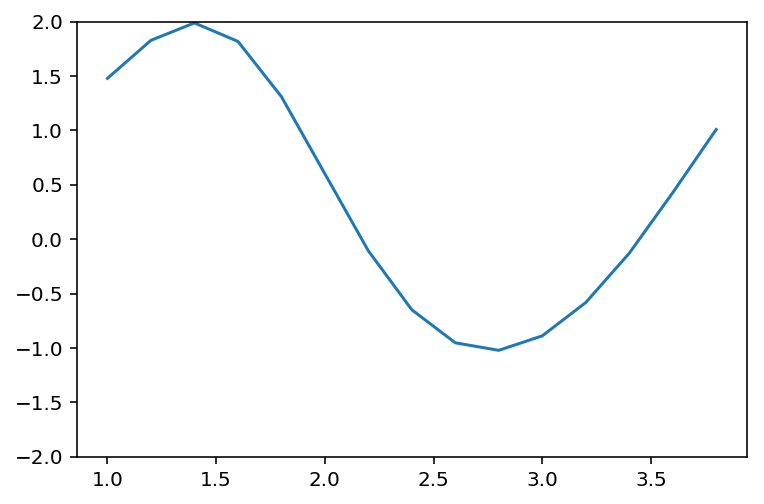

In [8]:
#ガウス過程の関数のうち1つを出力
plt.figure()
plt.ylim(-2.0,2.0)
plt.plot(x,y)

In [9]:
#コレスキー分解で得た分散共分散行列の下三角行列Lから多次元ガウス分布を出力

def viz_gp(x,L,title):
    Y = []
    n = 9
    for i in range(n):
        N = np.random.normal(0, 1.0, len(x))
        yi = L @ N
        Y += [yi]

    plt.figure()
    plt.ylim(-5.0,5.0)
    plt.title(title)
    for i in range(n):
        plt.plot(x,Y[i])


/Users/Kazuya/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


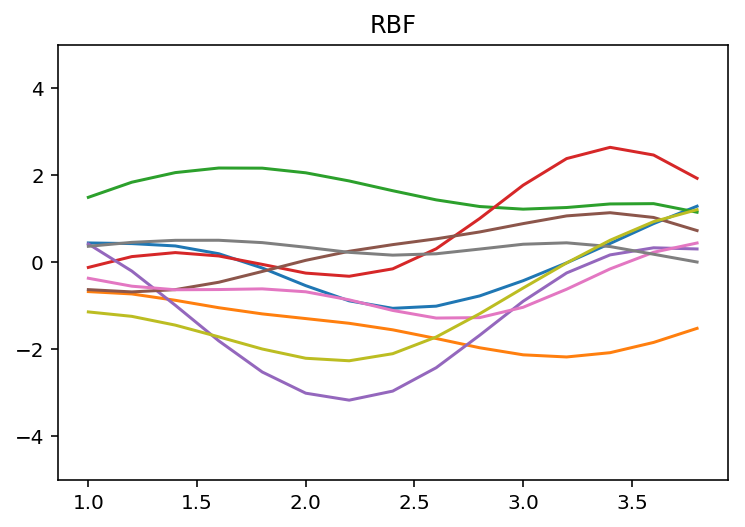

In [10]:
#関数を8本ずつ出力 (再実行で別の関数を出力)
#RBFカーネル

K_rbf = make_K(x)

#コレスキー分解
L_rbf = np.linalg.cholesky(K_rbf)
viz_gp(x,L_rbf,'RBF')

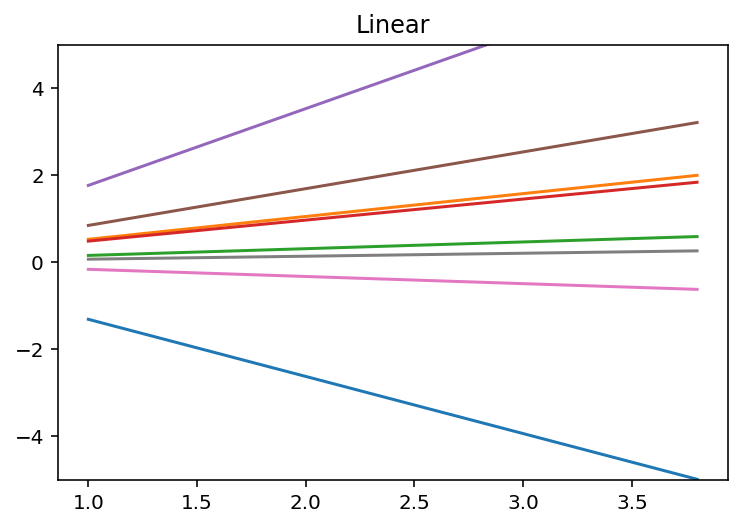

In [11]:
#線形カーネル

K_li = make_K(x, kernel='linear')

#多次元ガウス分布
y = np.random.multivariate_normal([0]*15, K_li, 9)
plt.figure()
plt.ylim(-5.0,5.0)
plt.title('Linear')
for i in range(8):
    plt.plot(x,y[i])


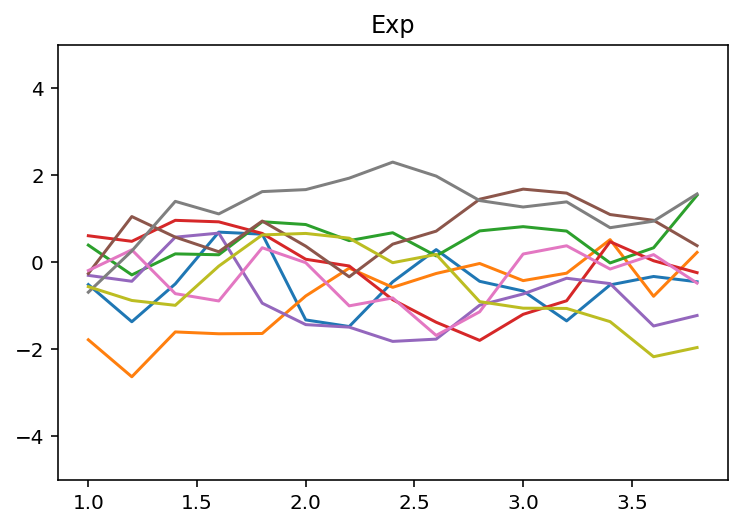

In [12]:
#指数カーネル

K_exp = make_K(x, kernel='exp')

#コレスキー分解
L_exp = np.linalg.cholesky(K_exp)
viz_gp(x,L_exp,'Exp')

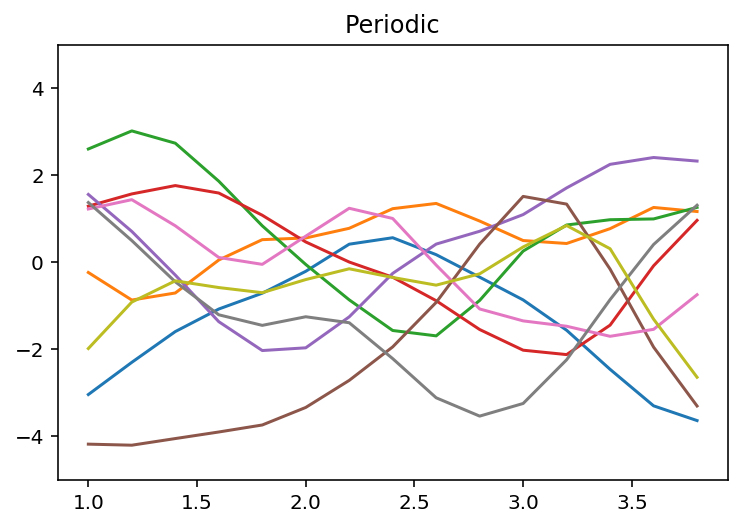

In [13]:
#周期カーネル

K_pe = make_K(x, t2=1/2, kernel='periodic')

#コレスキー分解
L_pe = np.linalg.cholesky(K_pe)
viz_gp(x,L_pe,'Periodic')

- ガウス過程回帰
(※観測ノイズは未実装)

In [231]:
def gpr(xtest, xtrain, ytrain, kernel):
    N = len(ytrain)
    M = len(xtest)
    K = np.matrix(np.zeros((N, N)))
    
    for n1 in range(0, N):
        for n2 in range(0, N):
            K[n1, n2] = kernel(xtrain[n1], xtrain[n2], 1.0, 1.0)
            
    yy = K.I * ytrain
    
    k = np.matrix(np.zeros((N,1))).T
    
    mu = []
    var = []
    
    for m in range(0, M):
        for n in range(0, N):
            k[0,n] = (kernel(xtrain[n], xtest[m], 1.0, 1.0))
        s = kernel(xtest[m], xtest[m], 1.0, 1.0)
        mu.append(np.asscalar(k * yy))
        var.append(np.asscalar(s - k * K.I * k.T))
    return (np.array(mu), np.array(var))

In [232]:
#学習データD
x = np.matrix([1,3,6,8]).T
y = np.matrix([-1,2,-2,3]).T

In [233]:
x_test = np.matrix(np.arange(0, 10, 0.25)).T

In [234]:
mu, var = gpr(x_test, x, y, k_RBF)

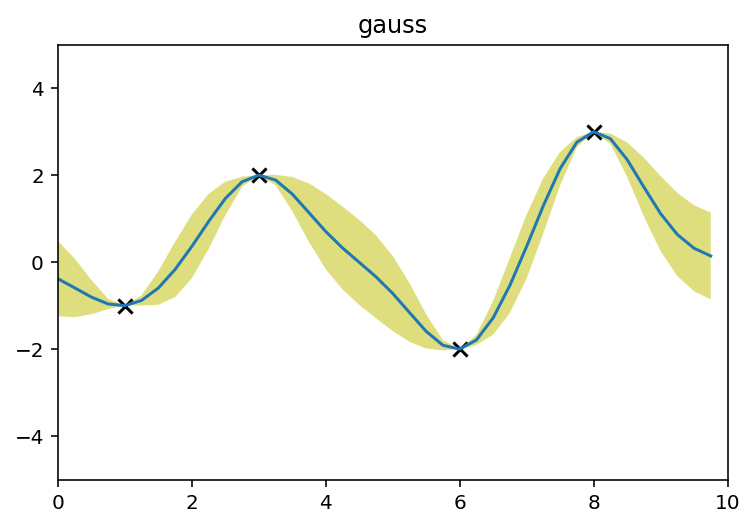

In [242]:
#グラフ化
plt.figure()
plt.xlim(0,10)
plt.ylim(-5.0,5.0)
plt.title('gauss')

#学習データ
plt.scatter(x.T.tolist()[0], y.T.tolist()[0], s=50, c='black',marker='x')

#予測値(期待値)
plt.plot(x_test.T.tolist()[0], mu)
plt.fill_between(x_test.T.tolist()[0], mu-var, mu+var, facecolor='y',alpha=0.5)

- 観測ノイズ実装

In [260]:
import math

def gaussian_kernel_2(x1, x2, theta1, theta2, theta3, diagonal):
    # input...
    #     1. matrix
    #     2. index n
    #     3. index n'
    #     4, theta1
    #     5, theta2
    #     6, theta3
    ret = theta1 * math.exp(-1 * ((x1-x2) ** 2 / theta2))
    if diagonal:
        ret += theta3
    return ret

In [261]:
def gpr2(xtest, xtrain, ytrain, kernel):
    N = len(ytrain)
    M = len(xtest)
    K = np.matrix(np.zeros((N, N)))
    
    for n1 in range(0, N):
        for n2 in range(0, N):
            K[n1, n2] = kernel(xtrain[n1], xtrain[n2], 1.0, 0.4, 0.1, n1==n2)
            
    yy = K.I * ytrain
    
    k = np.matrix(np.zeros((N,1))).T
    
    mu = []
    var = []
    
    for m in range(0, M):
        for n in range(0, N):
            k[0,n] = (kernel(xtrain[n], xtest[m], 1.0, 0.4, 0.1, False))
        s = kernel(xtest[m], xtest[m], 1.0, 0.4, 0.1, True)
        mu.append(np.asscalar(k * yy))
        var.append(np.asscalar(s - k * K.I * k.T))
    return (np.array(mu), np.array(var))

In [262]:
#学習データD
x = np.matrix([1,3,6,8]).T
y = np.matrix([-1,2,-2,3]).T

In [263]:
x_test = np.matrix(np.arange(0, 10, 0.25)).T

In [264]:
mu, var = gpr2(x_test, x, y, gaussian_kernel_2)

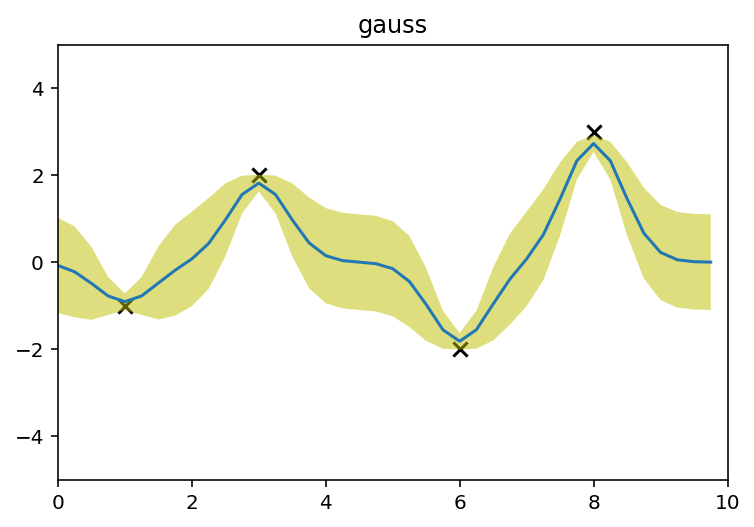

In [265]:
#グラフ化
plt.figure()
plt.xlim(0,10)
plt.ylim(-5.0,5.0)
plt.title('gauss')

#学習データ
plt.scatter(x.T.tolist()[0], y.T.tolist()[0], s=50, c='black',marker='x')

#予測値(期待値)
plt.plot(x_test.T.tolist()[0], mu)
plt.fill_between(x_test.T.tolist()[0], mu-var, mu+var, facecolor='y',alpha=0.5)